In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.viz import plot2d

from symlie.misc.utils_results import pivot, assert_columns_same, get_and_check_Ps, stringify_dict, aggregate_dataset, plot_best, return_table, plot_pivot
from symlie.misc.wandb import update_results_df, get_inspect_df
from symlie.model.setup import load_P_pred

In [2]:
# Select dataframe to analyze
check_df = 'results'
reload = False

# check_df = 'inspect'
# reload = True

match check_df:
    case 'results':
        if reload:
            update_results_df()
        df = pd.read_pickle('../logs/store/results_df.pkl')
        plot_single_pivot = False
    case 'inspect':
        df_inspect = get_inspect_df(reload = reload)
        df = df_inspect
        plot_single_pivot = True

print(df.shape)

(579, 49)


In [10]:
# Select step to analyze
step = 1
step = 2

datasets_new = [
    'sine1d',
    'sine2d',
    # 'flower',
    # 'mnist',
    # 'noise'
    # 'sine1d-noise',
]

datasets_inspect = [
    # 'sine1d-noise',
    # 'sine1dlayers',
    # 'sine1dtwo-hparam',
    # 'noise',
    'sine1d-noise',
]
datasets = {'results' : datasets_new, 'inspect' : datasets_inspect}[check_df]

default_log = [
    'sine2d',
    # 'flower',
    'noise',
    # 'sine1d-noise',
]

group_params = ['eps_mult', 'noise_std']
# hyper_params  = ['n_train', 'lr', 'svd_rank', 'net'] if step == 2 else ['lr', 'svd_rank']
hyper_params  = ['n_train', 'lr', 'net'] if step == 2 else ['lr', 'svd_rank']
# hyper_params  = ['n_train', 'lr', 'net', 'svd_rank'] if step == 2 else ['lr', 'svd_rank']

d_pivots, ddd, ddd_mean, ddd_std, mins = aggregate_dataset(
# d = aggregate_dataset(
    datasets=datasets,
    df = df,
    step = step,
    group_params = group_params,
    hyper_params = hyper_params,
    check_df=check_df,
    default_log=default_log,
    plot_single_pivot=False,
)

# d = d.mean().unstack().reset_index(level = 0, drop = True)

In [6]:
# d = list(d_pivots.values())[0]['d_pivot']
# d = d.iloc[:, d.columns.get_level_values(4) == 'Trained with noise']
# d = d.droplevel(4, axis = 1)

# d = d.min().unstack().reset_index(level = 0, drop = True)

# d.plot(kind = 'bar')

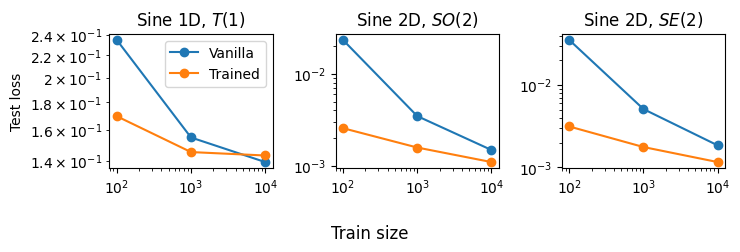

test_loss                      \
n_train                                       100                         
lr                                            0.001                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            2.937259  2.844392  2.939889   
                            0.1                 NaN  2.831010  2.829965   
../data/flower [0, 0, 1, 1] 0.0            2.795511  2.113411  2.245426   
                            0.1            2.485707  2.338358  2.112234   
               [0, 1, 1, 1] 0.0            2.488744  2.381774  1.864164   
                            0.1            2.616742  2.260929  2.572932   
../data/sine1d [0, 0, 1, 0] 0.5            0.403021  0.281951  0.361086   
../data/sine2d [0, 0, 1, 1] 0.1            0.051421  0.059522  0.069186   
               [0, 1, 1, 1] 0.1            0.074101  0.079811  0.139475   

                                                                            \
n_train                                                                      
lr                                                                           
net                                   Predict-TrainedP                       
seed                                                 1         2         3   
data_dir       eps_mult     noise_std                                        
../data/MNIST  [0, 1, 1, 1] 0.0                    NaN  2.195672  2.242971   
                            0.1               2.306753  2.187653       NaN   
../data/flower [0, 0, 1, 1] 0.0               1.096170  1.120773  1.104059   
                            0.1               1.109006  1.128359  1.119107   
               [0, 1, 1, 1] 0.0                    NaN  1.039864  1.050125   
                            0.1                    NaN  1.171049       NaN   
../data/sine1d [0, 0, 1, 0] 0.5               0.321519  0.217177  0.206340   
../data/sine2d [0, 0, 1, 1] 0.1               0.003099  0.003470  0.003915   
               [0, 1, 1, 1] 0.1               0.003956  0.005743  0.006546   

                                                                         \
n_train                                                                   
lr                                            0.010                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            4.217338  4.075702       NaN   
                            0.1            4.277594  4.368821  4.031054   
../data/flower [0, 0, 1, 1] 0.0            2.529043  1.898839  2.231631   
                            0.1            2.304017  2.099678  2.025271   
               [0, 1, 1, 1] 0.0                 NaN       NaN  1.910597   
                            0.1            2.467564  2.147691  2.438209   
../data/sine1d [0, 0, 1, 0] 0.5            0.249225  0.199787  0.256343   
../data/sine2d [0, 0, 1, 1] 0.1            0.022640  0.023749  0.023222   
               [0, 1, 1, 1] 0.1            0.038079  0.035776  0.032726   

                                                        ...                \
n_train                                                 ...         10000   
lr                                                      ...         0.010   
net                                   Predict-TrainedP  ... Predict-NoneP   
seed                                                 1  ...             3   
data_dir       eps_mult     noise_std                   ...                 
../data/MNIST  [0, 1, 1, 1] 0.0               2.529701  ...      2.004286   
                            0.1               2.479741  ...      1.969342   
../

In [11]:
if step == 2:
    plot_best(ddd_mean, ddd_std)
return_table(df, step, group_params, hyper_params)

# Map

In [5]:
assert step == 1

In [6]:
def filter_on_tags(df, tags):
    return df[df['tags'].astype(str).str.contains('|'.join(tags))]

In [14]:
df_map = pd.read_pickle('../logs/store/map_df.pkl')

df_map_sync = filter_on_tags(df_map, tags = ['sine1d', 'noise'])
df_map_sync = df_map_sync.reset_index(drop=True)
df_map_sync

,run_id,tags,data_kwargs,transform_kwargs,seed,data_dir,svd_rank
0,3gi8lu9g,"['new', 'sine1d']","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",3,../data/sine1d,NaN
1,lh3nnnij,"['new', 'sine1d']","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",2,../data/sine1d,NaN
2,cpw6d6pz,"['new', 'sine1d']","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",1,../data/sine1d,NaN
3,vjewun0b,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",3,../data/noise,NaN
4,g41hidqj,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",2,../data/noise,NaN
5,xxidyaps,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",1,../data/noise,NaN
6,5qbdclqh,"['new', 'noise']","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 1.0], 'only_flip'...",3,../data/noise,NaN
7,jb4gxwpb,"['new', 'noise']","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 1.0], 'only_flip'...",2,../data/noise,NaN
8,o7w74teb,"['new', 'noise']","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 1.0], 'only_flip'...",1,../data/noise,NaN
9,6pb0nn34,"['new', 'noise']","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",3,../data/noise,NaN


In [ ]:
sync_run_ids = list(df_map_sync['run_id'].values)

store_dir = '../logs/store'
# write the run_ids to a txt file
with open(os.path.join(store_dir, 'sync_run_ids.txt'), 'w') as f:
    f.write(f"{{{','.join(sync_run_ids)}}}")

# Let's check P's

In [ ]:
df

,lr,net,bias,name,seed,tags,test,A_low,n_val,train,...,args_processed,do_return_model,n_hidden_layers,transform_kwargs,use_P_from_noise,persistent_workers,run_name,test_loss,n_classes,svd_rank
0,0.010,TrainP,False,None,3,"['new', 'noise']",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,dandy-donkey-1960,6.474450e-05,NaN,NaN
1,0.001,TrainP,False,None,3,"['new', 'noise']",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,swept-lion-1959,3.812419e-02,NaN,NaN
2,0.100,TrainP,False,None,3,"['new', 'noise']",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,atomic-planet-1958,1.422213e-07,NaN,NaN
3,0.001,TrainP,False,None,2,"['new', 'noise']",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,royal-mountain-1957,3.862118e-02,NaN,NaN
4,0.100,TrainP,False,None,2,"['new', 'noise']",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,glamorous-snowflake-1955,1.425501e-07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,0.100,TrainP,False,None,1,"['inspect', 'new', 'noise', 'svd']",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,eager-firefly-2213,1.208998e-14,None,14.0
575,0.010,TrainP,False,None,1,"['inspect', 'new', 'noise', 'svd']",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,toasty-paper-2213,7.349598e-02,None,3.0
576,0.100,TrainP,False,None,1,"['inspect', 'new', 'noise', 'svd']",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,pleasant-pine-2213,9.551645e-12,None,30.0
577,0.100,TrainP,False,None,1,"['inspect', 'new', 'noise', 'svd']",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,devoted-firefly-2212,4.830418e-15,None,7.0


In [ ]:
# Select df
d = df_map_sync
# d = df_map
# d = df

# Filter d
d = filter_on_tags(d, tags = ['noise'])
transform_kwargs = {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False}
d = d[d['transform_kwargs'] == transform_kwargs]
d = d[d['svd_rank'] == 3]
map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir', 'svd_rank'])
print(f'map_kwargs = {map_kwargs}')

seeds = d['seed'].unique()
n_d = len(d)
assert len(seeds) == n_d, f'seeds={seeds}, n_d={n_d}'
print(f'seeds={seeds}')

map_kwargs = {'data_kwargs': {'grid_size': (1, 7), 'noise_std': 1}, 'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False}, 'data_dir': '../data/noise', 'svd_rank': 3.0}
seeds=[3 2 1]


In [ ]:
map_kwargs

{'data_kwargs': {'grid_size': (1, 7), 'noise_std': 1},
 'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False},
 'data_dir': '../data/noise',
 'svd_rank': 3.0}

Found run_id uutj0wk7
Found run_id ghhrf8d0
Found run_id ep9fxvi5


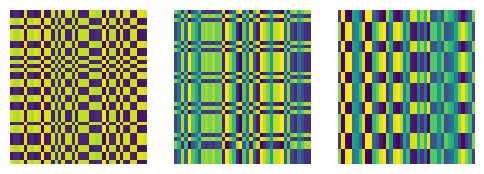

In [ ]:
Ps = get_and_check_Ps(seeds, map_kwargs, use_P_from_noise = True)
# Ps = get_and_check_Ps([1], map_kwargs)
plot2d(Ps, l = 2, max_grid = 40)

In [ ]:
import torch

from symlie.model.networks.implicit import LinearImplicit

In [ ]:
linear_implicit = LinearImplicit(
    in_features = 7, 
    out_features = 7,
    bias = False,
    hidden_implicit_layers = [49, 49],
)

implicit_statedict = torch.load('../logs/store/implicit_P/otnoxw0l.pt')
# linear_implicit.implicit_P.load_state_dict(implicit_statedict)

linear_implicit.eval()

NameError: name 'LinearImplicit' is not defined

In [ ]:
x = torch.randn((1,7))
x.shape

torch.Size([1, 7])

In [ ]:
linear_implicit(x)

tensor([[ 0.0080,  0.0532,  0.0000,  0.3132,  0.3418, -0.1157,  0.1974]],
       grad_fn=<MmBackward0>)